# Fine-tuning Vision Transformer (ViT) Model for Plants Dataset Classification
  This notebook demonstrates how to fine-tuning a Vision Transformer model to classify plants diseases from the Plant dataset, which includes 17 distinct classes of diseases that affect various plants.
  ## 📋 Table of Contents


1.   [Introduction](#-Introduction)
2.   [install dependencies and import the required libraries](#-installdependenciesandimporttherequiredlibraries)
3.   [Define Base Configurations](#-DefineBaseConfigurations)
4.   [Overview of the dataset](#-Overviewofthedataset)
5.   [Preprocess the datset](#-Preprocessthedatset)
6.   [Training](#-Training)
7.   [Evaluation of the model](#-Evaluationofthemodel)
8.   [Visualize some results](#-Visualizesomeresults)
9.   [Inference](#-Inference)



### [Introduction](#-Introduction)



  Vision Transformers (ViT) represent a paradigm shift in computer vision by applying the transformer architecture, originally designed for NLP tasks, to image classification problems.
  

  #### How Vision Transformers Work
  Unlike traditional CNNs that process images through convolutional layers, Vision Transformers work by:
  

*   Splitting an image into fixed-size patches.
*   Linearly embedding each patch.
*   Adding position embeddings.
*   Processing the resulting sequence with standard Transformer encoder blocks.
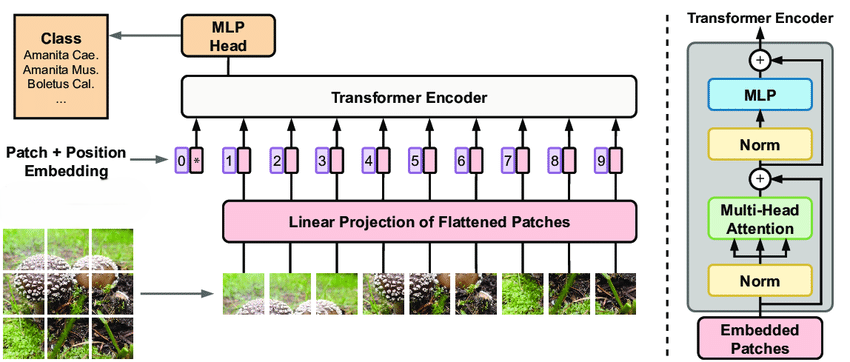




  
  



### [Install dependencies and import the required libraries](#-Installdependenciesandimporttherequiredlibraries)



*    Install dependencies

In [ ]:
pip install torch
pip install torchvision
pip install transformers
pip install evaluate
pip install matplotlib
pip install numpy
pip install pillow
pip install tabulate
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


*    Import the required libraries





In [ ]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer  ,EarlyStoppingCallback, TrainerCallback
import glob
import evaluate
import time
import shutil
import random
from tabulate import tabulate
import torch
import logging
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### [Define Base Configurations](#-DefineBaseConfigurations)



*   Specifies the directories where data will be saved during the process




In [ ]:
BASE_PATH = "Path to dataset"  # Main project directory
MODEL_NAME = "google/vit-base-patch16-224-in21k"  # Pretrained model name
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

# Valid image extensions
IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')

# Define directory structure
DIRECTORIES = {
    "train": os.path.join(BASE_PATH, "train"),
    "valid": os.path.join(BASE_PATH, "valid"),
    "test": os.path.join(BASE_PATH, "test"),
    "processed_train": os.path.join(BASE_PATH, "processed-train"),
    "processed_valid": os.path.join(BASE_PATH, "processed-valid"),
    "processed_test": os.path.join(BASE_PATH, "processed-test"),
    "output_dir": os.path.join(BASE_PATH, "vit-base-plant-diseases"),
    "final_model": os.path.join(BASE_PATH, "final-model"),
    "best_model": os.path.join(BASE_PATH, "best-model"),
}

# Function to create directories if they don't exist
def create_directories(directory_dict):
    for name, path in directory_dict.items():
        os.makedirs(path, exist_ok=True)
        print(f"Ensured directory exists: {path}")

# Create all directories
create_directories(DIRECTORIES)

# Example usage of directory paths
TRAIN_DIR = DIRECTORIES["train"]
VALID_DIR = DIRECTORIES["valid"]
TEST_DIR = DIRECTORIES["test"]
processed_train_dir = DIRECTORIES["processed_train"]
processed_valid_dir = DIRECTORIES["processed_valid"]
processed_test_dir = DIRECTORIES["processed_test"]
output_dir = DIRECTORIES["output_dir"]
final_model_dir = DIRECTORIES["final_model"]
best_model_dir = DIRECTORIES["best_model"]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Ensured directory exists: /kaggle/working/plant-dataset/train
Ensured directory exists: /kaggle/working/plant-dataset/valid
Ensured directory exists: /kaggle/working/plant-dataset/test
Ensured directory exists: /kaggle/working/plant-dataset/processed-train
Ensured directory exists: /kaggle/working/plant-dataset/processed-valid
Ensured directory exists: /kaggle/working/plant-dataset/processed-test
Ensured directory exists: /kaggle/working/plant-dataset/vit-base-plant-diseases
Ensured directory exists: /kaggle/working/plant-dataset/final-model
Ensured directory exists: /kaggle/working/plant-dataset/best-model


Later in this task we will use logger instead of print statements for several reasons like

*   Unlike print, which only outputs to the console, logger.info sends messages to all configured handlers—here, both the file and console. This creates a permanent record in training_log.txt alongside runtime console output.
*   The logging.basicConfig format (%(asctime)s - %(message)s) adds a timestamp to each logger.info call, enabling precise tracking of events like the dataset summary for debugging or auditing.
*  Offers portability and configurability; you can easily adjust log levels, formats, or handlers (e.g., adding email notifications) in one place, whereas print statements are static and require changes at every instance. This flexibility allows output adaptation without altering the summary code.



In [ ]:
# Setup logging
LOG_FILE = "Path to save the file" # Replace with the pathe where you need to save the logs file
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.handlers = []  # Clear any existing handlers

file_handler = logging.FileHandler(LOG_FILE)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(message)s'))
logger.addHandler(file_handler)

console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(message)s'))
logger.addHandler(console_handler)

logger.info("Logging initialized successfully")

2025-03-19 17:54:26,412 - Logging initialized successfully


This step is critical because process often involve randomness, shuffling datasets, initializing model weights, or splitting data into training and validation sets.

By setting the same random seed here, make all random operations are synchronized to produce identical results each time the code is run.

This eliminates variability due to randomness, making it easier to debug, compare results, or share reproducible outcomes with others.

 The value 42 is arbitrary but it just commonly used in programming communities.



In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

### [Overview of the dataset](#-Overviewofthedataset)


In this section we provide an overview of what we have in the dataset including the total number of images, the number of classes, and the number of images per class. Additionally we display example images for each class to illustrate the data.

In [ ]:
def count_images_in_folders(root_folder):
    """Count images and classes in subfolders and display results in a table."""
    total_images = 0  # Tracks total number of images across all subfolders
    num_of_classes = 0  # Tracks number of subfolders (classes)
    table_data = []  # List to store rows for the table

    # Verify root folder exists
    if not os.path.exists(root_folder):
        print(f"Error: Directory '{root_folder}' not found.")
        return

    # Loop through all items in the root folder
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)  # Full path to subfolder

        # Check if the item is a directory
        if os.path.isdir(subfolder_path):
            image_count = 0  # Counter for images in this subfolder
            num_of_classes += 1

            # Count files with common image extensions in the subfolder
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if os.path.isfile(file_path) and file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_count += 1

            total_images += image_count  # Add to total images
            table_data.append([subfolder, image_count])  # Add row to table data

    # Display results in a table
    headers = ["Class Name", "Image Count"]  # Table column headers
    print(f"\nImage Counts for '{root_folder}':")
    print(tabulate(table_data, headers=headers, tablefmt="pretty", colalign=("left", "center")))

    # Print summary statistics
    print(f"\nTotal images across all classes: {total_images}")
    print(f"Total number of classes: {num_of_classes}")

# Call the function to count
count_images_in_folders(TRAIN_DIR)  # Process training folder
print('*' * 100)  # Separator line
count_images_in_folders(VALID_DIR)  # Process validation folder


Image Counts for '/kaggle/working/plant-dataset/train':
+----------------------------------------------------+-------------+
| Class Name                                         | Image Count |
+----------------------------------------------------+-------------+
| Tomato___Tomato_mosaic_virus                       |    1790     |
| Tomato___Tomato_Yellow_Leaf_Curl_Virus             |    1961     |
| Corn_(maize)___Northern_Leaf_Blight                |    1908     |
| Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot |    1642     |
| Tomato___Late_blight                               |    1851     |
| Potato___Early_blight                              |    1939     |
| Tomato___Bacterial_spot                            |    1702     |
| Tomato___Target_Spot                               |    1827     |
| Corn_(maize)___Common_rust_                        |    1907     |
| Tomato___Leaf_Mold                                 |    1882     |
| Potato___Late_blight                        

In [ ]:
def show_training_samples(train_root, examples_per_class=1, size=(350, 350), seed=None):
    """Create and return a grid of sample training images with class labels."""

    # Check if train_root exists
    if not os.path.exists(train_root):
        print(f"Error: Directory '{train_root}' not found.")
        return None

    # Set random seed for reproducibility
    if seed is not None:
        random.seed(seed)

    # Collect sample image paths
    train_samples = {}
    for subfolder in os.listdir(train_root):
        subfolder_path = os.path.join(train_root, subfolder)
        if os.path.isdir(subfolder_path):
            image_files = [
                os.path.join(subfolder_path, file)
                for file in os.listdir(subfolder_path)
                if file.lower().endswith(IMAGE_EXTENSIONS)
            ]
            if image_files:
                num_available = len(image_files)
                num_to_sample = min(examples_per_class, num_available)
                selected = random.sample(image_files, num_to_sample)
                train_samples[subfolder] = selected if examples_per_class > 1 else selected[0]


    # Create image grid
    width, height = size  # Unpack width and height
    labels = sorted(train_samples.keys())  # Sorted list of class labels
    grid_width = examples_per_class * width
    grid_height = len(labels) * height
    grid = Image.new('RGB', size=(grid_width, grid_height))  # New RGB grid
    draw = ImageDraw.Draw(grid)  # Drawing context

    # Load font with fallback
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)
    except Exception:
        font = ImageFont.load_default()
        print("Warning: Custom font not found, using default font")

    # Populate the grid
    for label_idx, label in enumerate(labels):
        samples = train_samples[label]
        if examples_per_class == 1:
            samples = [samples]

        for i, image_path in enumerate(samples):
            try:
                image = Image.open(image_path)  # Open image
                position = (i * width, label_idx * height)  # Calculate paste position
                grid.paste(image.resize(size), box=position)  # Resize and paste image
                if i == 0:  # Label only the first image in each row
                    display_name = (label[:28] + '...') if len(label) > 28 else label
                    draw.text(position, display_name, fill=(255, 255, 255), font=font)
            except Exception as e:
                print(f"Error loading image for '{label}': {e}")

    return grid

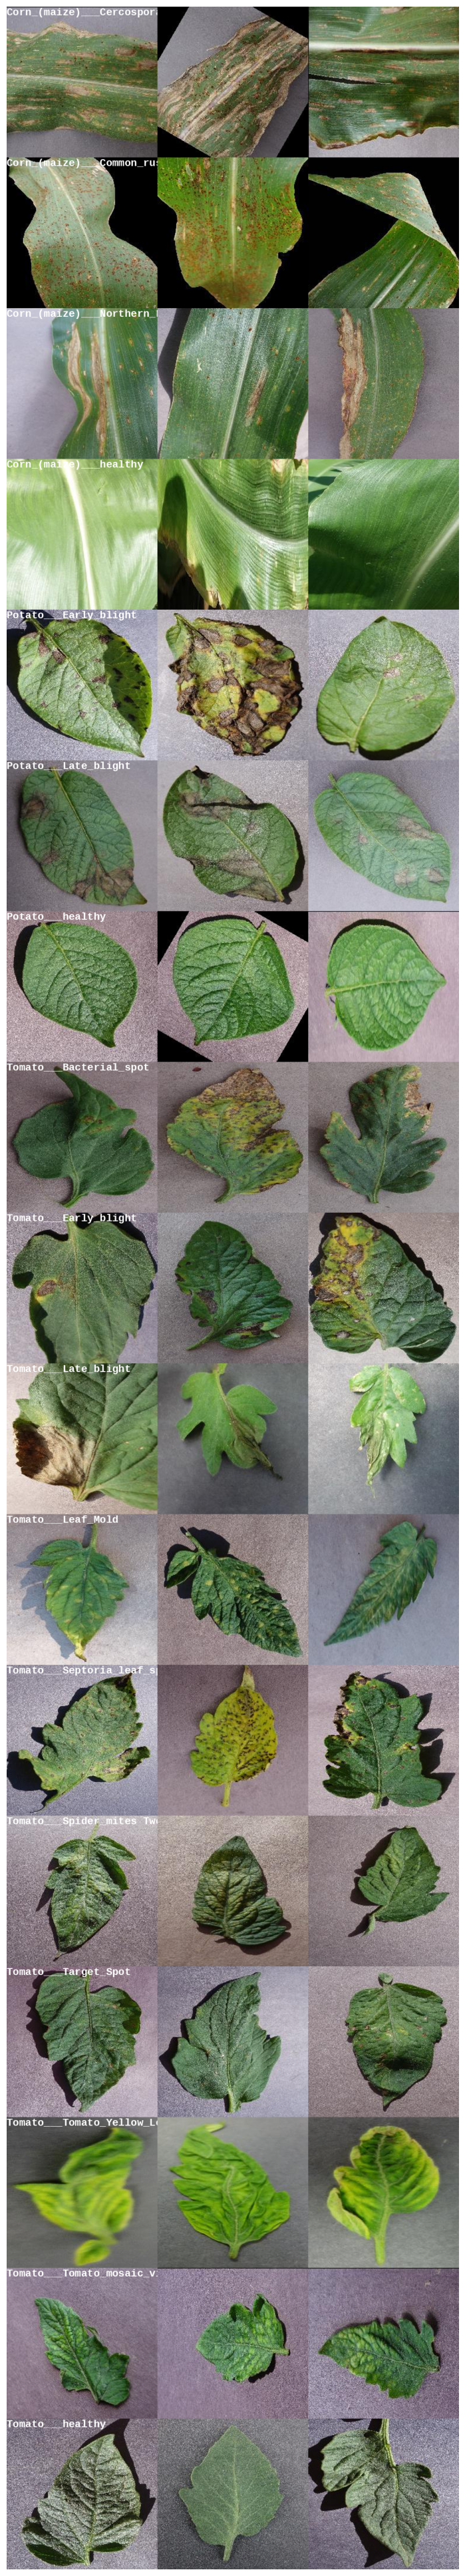

In [ ]:
grid = show_training_samples(TRAIN_DIR, examples_per_class=3, seed=random_seed)
plt.figure(figsize=(20, 50))  # Adjust size as needed
plt.imshow(grid)  # Directly display RGB PIL Image
plt.axis('off')  # Hide axes
plt.show()

### [Preprocess the datset](#-Preprocessthedatset)

*  Create the test set by subsetting it from the training dataset and verifying its successful execution.

In [ ]:
SAMPLE_PERCENTAGE = 0.1  # Fraction of training images to move to test (10%)

# Function to count images in subfolders
def count_images_in_subfolders(folder_path):
    """Count the number of image files in each subfolder of the given directory."""
    counts = {}  # Dictionary to store subfolder: image_count pairs
    if not os.path.exists(folder_path):
        print(f"Error: Directory {folder_path} not found.")
        return counts
    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
        counts[subfolder] = len(images)
    return counts


# Function to create test set by sampling and moving images
def create_test_set(train_dir, test_dir, sample_percentage):
    """Sample a percentage of images from train_dir and move them to test_dir."""
    os.makedirs(test_dir, exist_ok=True)  # Ensure test directory exists
    class_folders = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]
    if len(class_folders) != 17:  # Validate expected number of classes
        print(f"Warning: Found {len(class_folders)} subfolders, expected 17.")
    for class_folder in class_folders:
        train_class_path = os.path.join(train_dir, class_folder)
        test_class_path = os.path.join(test_dir, class_folder)
        os.makedirs(test_class_path, exist_ok=True)  # Ensure class folder in test exists
        images = [f for f in os.listdir(train_class_path) if os.path.isfile(os.path.join(train_class_path, f))]
        num_images = len(images)
        num_samples = max(1, int(num_images * sample_percentage))  # Ensure at least 1 image
        sampled_images = random.sample(images, num_samples)
        for image in sampled_images:
            src_path = os.path.join(train_class_path, image)
            dest_path = os.path.join(test_class_path, image)
            shutil.move(src_path, dest_path)
    print(f"Test set created at {test_dir} with {sample_percentage * 100}% of train data.")


In [ ]:
# Get initial image counts from training directory to use it later in the comparison
train_counts_before = count_images_in_subfolders(TRAIN_DIR)

# Execute test set creation
create_test_set(TRAIN_DIR, TEST_DIR, SAMPLE_PERCENTAGE)

Test set created at /kaggle/working/plant-dataset/test with 10.0% of train data.


*   A comparison of the dataset sizes before and after the split is performed to ensure everything is correct

In [ ]:
# Get updated counts after sampling
train_counts_after = count_images_in_subfolders(TRAIN_DIR)
test_counts = count_images_in_subfolders(TEST_DIR)

# Prepare data for comparison table
table_data = []
total_before, total_after, total_moved = 0, 0, 0
for subfolder in sorted(train_counts_before.keys()):
    before = train_counts_before.get(subfolder, 0)
    after = train_counts_after.get(subfolder, 0)
    moved = test_counts.get(subfolder, 0)
    percent_moved = (moved / before * 100) if before > 0 else 0
    # Shorten subfolder names for display clarification
    short_name = subfolder.replace('Corn_(maize)_', 'Corn ').replace('Tomato_', 'Tomato ').replace('Potato_', 'Potato ')
    table_data.append([short_name, before, after, moved, f"{percent_moved:.1f}%"])
    total_before += before
    total_after += after
    total_moved += moved

# Append total row to table
table_data.append(["Total", total_before, total_after, total_moved, f"{(total_moved / total_before * 100):.1f}%"])

# Display comparison table
headers = ["Subfolder", "Before", "After", "Moved to Test", "% Moved"]
print("\nComparison of Image Counts per Subfolder:")
print(tabulate(table_data, headers=headers, tablefmt="pretty", colalign=("left", "center", "center", "center", "center")))


Comparison of Image Counts per Subfolder:
+-----------------------------------------------+--------+-------+---------------+---------+
| Subfolder                                     | Before | After | Moved to Test | % Moved |
+-----------------------------------------------+--------+-------+---------------+---------+
| Corn __Cercospora_leaf_spot Gray_leaf_spot    |  1642  | 1478  |      164      |  10.0%  |
| Corn __Common_rust_                           |  1907  | 1717  |      190      |  10.0%  |
| Corn __Northern_Leaf_Blight                   |  1908  | 1718  |      190      |  10.0%  |
| Corn __healthy                                |  1859  | 1674  |      185      |  10.0%  |
| Potato __Early_blight                         |  1939  | 1746  |      193      |  10.0%  |
| Potato __Late_blight                          |  1939  | 1746  |      193      |  10.0%  |
| Potato __healthy                              |  1824  | 1642  |      182      |  10.0%  |
| Tomato __Bacterial_spot  

*  After subset the test set make a comparison for all dataset folders

In [ ]:

def compare_images_in_folders(train_root, valid_root, test_root):
    """Compare image counts across train, valid, and test folders in a table."""


    def filter_counts(folder_path):
        """Helper function to filter counts by image extensions."""
        counts = count_images_in_subfolders(folder_path)
        filtered_counts = {}
        for subfolder, count in counts.items():
            subfolder_path = os.path.join(folder_path, subfolder)
            image_count = sum(
                1 for f in os.listdir(subfolder_path)
                if os.path.isfile(os.path.join(subfolder_path, f)) and f.lower().endswith(IMAGE_EXTENSIONS)
            )
            filtered_counts[subfolder] = image_count
        return filtered_counts

    # Get counts for all folders
    train_counts = filter_counts(train_root)
    valid_counts = filter_counts(valid_root)
    test_counts = filter_counts(test_root)

    # Calculate totals
    train_total = sum(train_counts.values())
    valid_total = sum(valid_counts.values())
    test_total = sum(test_counts.values())

    # Get all unique subfolders
    all_subfolders = sorted(set(train_counts.keys()) | set(valid_counts.keys()) | set(test_counts.keys()))

    # Prepare table data
    table_data = []
    for subfolder in all_subfolders:
        train_num = train_counts.get(subfolder, 0)
        valid_num = valid_counts.get(subfolder, 0)
        test_num = test_counts.get(subfolder, 0)
        difference = train_num - valid_num
        display_name = (subfolder[:28] + '...') if len(subfolder) > 28 else subfolder
        table_data.append([display_name, train_num, valid_num, difference, test_num])

    # Add total row
    table_data.append(["Total Images", train_total, valid_total, "", test_total])
    table_data.append(["Total Classes", len(train_counts), len(valid_counts), "", len(test_counts)])

    # Display table
    headers = ["Class Name", "Train", "Valid", "Difference", "Test"]
    print("\n=== Image Count Comparison: Train vs Valid vs Test ===")
    print(tabulate(table_data, headers=headers, tablefmt="pretty", numalign="right", stralign="left"))


In [ ]:
# Run the comparison
compare_images_in_folders(TRAIN_DIR, VALID_DIR, TEST_DIR)


=== Image Count Comparison: Train vs Valid vs Test ===
+---------------------------------+-------+-------+------------+------+
| Class Name                      | Train | Valid | Difference | Test |
+---------------------------------+-------+-------+------------+------+
| Corn_(maize)___Cercospora_le... | 1478  | 410   | 1068       | 164  |
| Corn_(maize)___Common_rust_     | 1717  | 477   | 1240       | 190  |
| Corn_(maize)___Northern_Leaf... | 1718  | 477   | 1241       | 190  |
| Corn_(maize)___healthy          | 1674  | 465   | 1209       | 185  |
| Potato___Early_blight           | 1746  | 485   | 1261       | 193  |
| Potato___Late_blight            | 1746  | 485   | 1261       | 193  |
| Potato___healthy                | 1642  | 456   | 1186       | 182  |
| Tomato___Bacterial_spot         | 1532  | 425   | 1107       | 170  |
| Tomato___Early_blight           | 1728  | 480   | 1248       | 192  |
| Tomato___Late_blight            | 1666  | 463   | 1203       | 185  |
| Tomato

*  Process the dataset and convert raw images to .pt files (Pytorch tensor)

  1. These .pt files were saved to disk in batches to avoid memory issues during preprocessing and to enable efficient loading later.
  
  2.  Preprocessing images with ViTImageProcessor is computationally expensive and doesn’t need to be repeated every time training the model, so by saving preprocessed data as .pt files, we perform this step once and reuse the results.

  3.  Loading preprocessed .pt files is much faster than reprocessing raw images on-the-fly during training, especially for large datasets.

In [ ]:

def process_batch(images, label):
    """Process a batch of images into model-ready tensors."""
    inputs = processor(images, return_tensors='pt')  # Process images with ViT processor
    inputs['pixel_values'] = inputs['pixel_values'].to(torch.float16)  # Convert to float16
    batch_size = len(images)
    inputs['labels'] = torch.tensor([label] * batch_size, dtype=torch.long)  # Create labels tensor
    return inputs

def process_and_save_all_images(folder_root, output_dir, label_mapping=None, batch_size=16):
    """Process all images in a folder, save as tensors, and return label mapping."""

    total_images = 0  # Total images processed
    summary_data = []  # For tabulate summary

    # Check if folder exists
    if not os.path.exists(folder_root):
        print(f"Error: Directory '{folder_root}' not found.")
        return label_mapping

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    subfolders = sorted([s for s in os.listdir(folder_root) if os.path.isdir(os.path.join(folder_root, s))])
    if not subfolders:
        print(f"Warning: No subfolders found in '{folder_root}'.")
        return label_mapping

    # Create label mapping if not provided (use this for training)
    if label_mapping is None:
        label_mapping = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

    for subfolder in subfolders:
        if subfolder not in label_mapping:
            print(f"Warning: '{subfolder}' not in label mapping, skipping.")
            continue

        label_id = label_mapping[subfolder]
        subfolder_path = os.path.join(folder_root, subfolder)
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(IMAGE_EXTENSIONS)]

        if not image_files:
            print(f"Warning: No images found in '{subfolder}'.")
            continue

        print(f"\nProcessing '{subfolder}' ({len(image_files)} images)")
        batches_saved = 0

        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            try:
                images = [Image.open(os.path.join(subfolder_path, f)).convert("RGB") for f in batch_files]
                inputs = process_batch(images, label_id)
                batch_idx = i // batch_size
                save_path = os.path.join(output_dir, f"{subfolder}_batch_{batch_idx}.pt")
                torch.save({'pixel_values': inputs['pixel_values'], 'labels': inputs['labels']}, save_path)
                batches_saved += 1
                total_images += len(images)
                print(f"  Saved batch {batch_idx + 1}: {inputs['pixel_values'].shape}")
            except Exception as e:
                print(f"  Error processing batch {batch_idx + 1} in '{subfolder}': {e}")

        summary_data.append([subfolder, len(image_files), batches_saved])

    # Save label mapping for training folder
    if folder_root == TRAIN_DIR:
        torch.save(label_mapping, os.path.join(output_dir, "label_mapping.pt"))

    # Display summary table
    headers = ["Subfolder", "Images", "Batches Saved"]
    print(f"\nSummary for '{folder_root}':")
    print(tabulate(summary_data, headers=headers, tablefmt="pretty", numalign="right"))
    print(f"Total images processed and saved: {total_images}")

    return label_mapping

In [ ]:
# Process training folders
print("***Processing Training Folder***")
label_mapping = process_and_save_all_images(TRAIN_DIR, processed_train_dir)

***Processing Training Folder***

Processing 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' (1478 images)
  Saved batch 1: torch.Size([16, 3, 224, 224])
  Saved batch 2: torch.Size([16, 3, 224, 224])
  Saved batch 3: torch.Size([16, 3, 224, 224])
  Saved batch 4: torch.Size([16, 3, 224, 224])
  Saved batch 5: torch.Size([16, 3, 224, 224])
  Saved batch 6: torch.Size([16, 3, 224, 224])
  Saved batch 7: torch.Size([16, 3, 224, 224])
  Saved batch 8: torch.Size([16, 3, 224, 224])
  Saved batch 9: torch.Size([16, 3, 224, 224])
  Saved batch 10: torch.Size([16, 3, 224, 224])
  Saved batch 11: torch.Size([16, 3, 224, 224])
  Saved batch 12: torch.Size([16, 3, 224, 224])
  Saved batch 13: torch.Size([16, 3, 224, 224])
  Saved batch 14: torch.Size([16, 3, 224, 224])
  Saved batch 15: torch.Size([16, 3, 224, 224])
  Saved batch 16: torch.Size([16, 3, 224, 224])
  Saved batch 17: torch.Size([16, 3, 224, 224])
  Saved batch 18: torch.Size([16, 3, 224, 224])
  Saved batch 19: torch.Size([16,

In [ ]:
# Process validation folders
print("***Processing Validation Folder***")
process_and_save_all_images(VALID_DIR, processed_valid_dir, label_mapping)

***Processing Validation Folder***

Processing 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' (410 images)
  Saved batch 1: torch.Size([16, 3, 224, 224])
  Saved batch 2: torch.Size([16, 3, 224, 224])
  Saved batch 3: torch.Size([16, 3, 224, 224])
  Saved batch 4: torch.Size([16, 3, 224, 224])
  Saved batch 5: torch.Size([16, 3, 224, 224])
  Saved batch 6: torch.Size([16, 3, 224, 224])
  Saved batch 7: torch.Size([16, 3, 224, 224])
  Saved batch 8: torch.Size([16, 3, 224, 224])
  Saved batch 9: torch.Size([16, 3, 224, 224])
  Saved batch 10: torch.Size([16, 3, 224, 224])
  Saved batch 11: torch.Size([16, 3, 224, 224])
  Saved batch 12: torch.Size([16, 3, 224, 224])
  Saved batch 13: torch.Size([16, 3, 224, 224])
  Saved batch 14: torch.Size([16, 3, 224, 224])
  Saved batch 15: torch.Size([16, 3, 224, 224])
  Saved batch 16: torch.Size([16, 3, 224, 224])
  Saved batch 17: torch.Size([16, 3, 224, 224])
  Saved batch 18: torch.Size([16, 3, 224, 224])
  Saved batch 19: torch.Size([16

{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0,
 'Corn_(maize)___Common_rust_': 1,
 'Corn_(maize)___Northern_Leaf_Blight': 2,
 'Corn_(maize)___healthy': 3,
 'Potato___Early_blight': 4,
 'Potato___Late_blight': 5,
 'Potato___healthy': 6,
 'Tomato___Bacterial_spot': 7,
 'Tomato___Early_blight': 8,
 'Tomato___Late_blight': 9,
 'Tomato___Leaf_Mold': 10,
 'Tomato___Septoria_leaf_spot': 11,
 'Tomato___Spider_mites Two-spotted_spider_mite': 12,
 'Tomato___Target_Spot': 13,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14,
 'Tomato___Tomato_mosaic_virus': 15,
 'Tomato___healthy': 16}

In [ ]:
# Process test folders
print("***Processing Test Folder***")
process_and_save_all_images(TEST_DIR, processed_test_dir, label_mapping)

***Processing Test Folder***

Processing 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot' (164 images)
  Saved batch 1: torch.Size([16, 3, 224, 224])
  Saved batch 2: torch.Size([16, 3, 224, 224])
  Saved batch 3: torch.Size([16, 3, 224, 224])
  Saved batch 4: torch.Size([16, 3, 224, 224])
  Saved batch 5: torch.Size([16, 3, 224, 224])
  Saved batch 6: torch.Size([16, 3, 224, 224])
  Saved batch 7: torch.Size([16, 3, 224, 224])
  Saved batch 8: torch.Size([16, 3, 224, 224])
  Saved batch 9: torch.Size([16, 3, 224, 224])
  Saved batch 10: torch.Size([16, 3, 224, 224])
  Saved batch 11: torch.Size([4, 3, 224, 224])

Processing 'Corn_(maize)___Common_rust_' (190 images)
  Saved batch 1: torch.Size([16, 3, 224, 224])
  Saved batch 2: torch.Size([16, 3, 224, 224])
  Saved batch 3: torch.Size([16, 3, 224, 224])
  Saved batch 4: torch.Size([16, 3, 224, 224])
  Saved batch 5: torch.Size([16, 3, 224, 224])
  Saved batch 6: torch.Size([16, 3, 224, 224])
  Saved batch 7: torch.Size([16, 3, 22

{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0,
 'Corn_(maize)___Common_rust_': 1,
 'Corn_(maize)___Northern_Leaf_Blight': 2,
 'Corn_(maize)___healthy': 3,
 'Potato___Early_blight': 4,
 'Potato___Late_blight': 5,
 'Potato___healthy': 6,
 'Tomato___Bacterial_spot': 7,
 'Tomato___Early_blight': 8,
 'Tomato___Late_blight': 9,
 'Tomato___Leaf_Mold': 10,
 'Tomato___Septoria_leaf_spot': 11,
 'Tomato___Spider_mites Two-spotted_spider_mite': 12,
 'Tomato___Target_Spot': 13,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14,
 'Tomato___Tomato_mosaic_virus': 15,
 'Tomato___healthy': 16}

*  Calculate and display total size of processed data (optional)


In [ ]:
# Check total size of processed data
folder_stats = [
    ["Train", sum(os.path.getsize(os.path.join(processed_train_dir, f)) for f in os.listdir(processed_train_dir) if f.endswith('.pt'))],
    ["Valid", sum(os.path.getsize(os.path.join(processed_valid_dir, f)) for f in os.listdir(processed_valid_dir) if f.endswith('.pt'))],
    ["Test", sum(os.path.getsize(os.path.join(processed_test_dir, f)) for f in os.listdir(processed_test_dir) if f.endswith('.pt'))],
]
total_size = sum(size for _, size in folder_stats) / (1024 ** 3)
folder_stats.append(["Total", total_size])
print("\nSize of Processed Data:")
print(tabulate(
    [[name, f"{size / (1024 ** 3):.2f} GB" if name != "Total" else f"{size:.2f} GB"] for name, size in folder_stats],
    headers=["Folder", "Size"],
    tablefmt="pretty",
    numalign="right"
))


Size of Processed Data:
+--------+----------+
| Folder |   Size   |
+--------+----------+
| Train  | 7.92 GB  |
| Valid  | 2.20 GB  |
|  Test  | 0.88 GB  |
| Total  | 11.00 GB |
+--------+----------+


*  Prepare the training, validation, and test Datasets for the training process

  Here we are not reprocessing the data by reapplying ViTImageProcessor. Instead, we’re loading the already processed .pt files and organizes the saved tensors into a a structured Dataset for efficient, on demand loading during model training, validation, and testing.

In [ ]:
class PreprocessedDataset(Dataset):
    """A PyTorch Dataset for loading preprocessed .pt files."""
    def __init__(self, data_dir):
        """Initialize the dataset with a directory of .pt files."""
        if not os.path.exists(data_dir):
            raise ValueError(f"Directory '{data_dir}' does not exist.")

        self.file_list = sorted(glob.glob(os.path.join(data_dir, "*.pt")))
        if not self.file_list:
            raise ValueError(f"No .pt files found in '{data_dir}'.")

        self.samples = []
        for file in self.file_list:
            try:
                data = torch.load(file, weights_only=False)
                if 'pixel_values' not in data or 'labels' not in data:
                    logger.warning(f"Skipping malformed file: {file}")
                    continue
                num_samples = data['pixel_values'].shape[0]
                self.samples.extend((file, i) for i in range(num_samples))
            except Exception as e:
                logger.error(f"Error scanning '{file}': {str(e)}")

        if not self.samples:
            raise ValueError(f"No valid samples loaded from '{data_dir}'.")
        logger.info(f"Loaded {len(self.samples)} samples from {len(self.file_list)} files in '{data_dir}'")

    def __len__(self):
        """Return the total number of samples."""
        return len(self.samples)

    def __getitem__(self, idx):
        """Retrieve a sample by index."""
        file_path, sample_idx = self.samples[idx]
        try:
            data = torch.load(file_path, weights_only=False)
            return {
                'pixel_values': data['pixel_values'][sample_idx],
                'labels': data['labels'][sample_idx]
            }
        except Exception as e:
            logger.error(f"Error loading '{file_path}' at index {sample_idx}: {str(e)}")
            raise


In [ ]:
# Create datasets
train_dataset = PreprocessedDataset(processed_train_dir)
valid_dataset = PreprocessedDataset(processed_valid_dir)
test_dataset = PreprocessedDataset(processed_test_dir)

2025-03-19 18:02:24,746 - Skipping malformed file: /kaggle/working/plant-dataset/processed-train/label_mapping.pt
2025-03-19 18:02:24,747 - Loaded 28234 samples from 1774 files in '/kaggle/working/plant-dataset/processed-train'
2025-03-19 18:02:25,272 - Loaded 7840 samples from 498 files in '/kaggle/working/plant-dataset/processed-valid'
2025-03-19 18:02:25,493 - Loaded 3129 samples from 203 files in '/kaggle/working/plant-dataset/processed-test'


In [ ]:
# Summarize datasets after creation
dataset_summary = [
    ["Train", len(train_dataset), len(glob.glob(os.path.join(processed_train_dir, "*.pt")))],
    ["Valid", len(valid_dataset), len(glob.glob(os.path.join(processed_valid_dir, "*.pt")))],
    ["Test", len(test_dataset), len(glob.glob(os.path.join(processed_test_dir, "*.pt")))]
]
# Here we notice the diff between using logger and print statment
summary_table = tabulate(dataset_summary, headers=["Split", "Samples", "Files"], tablefmt="pretty", numalign="right")
logger.info("\nDataset Summary:\n%s", summary_table)
print("\nDataset Summary:")
print(tabulate(dataset_summary, headers=["Split", "Samples", "Files"], tablefmt="pretty", numalign="right"))

2025-03-19 18:02:29,970 - 
Dataset Summary:
+-------+---------+-------+
| Split | Samples | Files |
+-------+---------+-------+
| Train |  28234  | 1774  |
| Valid |  7840   |  498  |
| Test  |  3129   |  203  |
+-------+---------+-------+



Dataset Summary:
+-------+---------+-------+
| Split | Samples | Files |
+-------+---------+-------+
| Train |  28234  | 1774  |
| Valid |  7840   |  498  |
| Test  |  3129   |  203  |
+-------+---------+-------+


*  Doing some Verification before starting the training process to avoiding
errors in training by :
  
  1. Confirms that the datasets were loaded correctly and contain the expected number of samples.
  2.  Inspect and displays a few random samples from train_dataset to verify their format and content.
  3.  Samples a subset of labels from train_dataset to estimate the distribution of classes.

In [ ]:


# Print dataset sizes
sizes = [
    ["Train", len(train_dataset)],
    ["Validation", len(valid_dataset)],
    ["Test", len(test_dataset)]
]
print("Dataset Sizes:")
print(tabulate(sizes, headers=["Split", "Samples"], tablefmt="pretty", numalign="right"))

# Inspect random samples
random_indices = random.sample(range(len(train_dataset)), min(5, len(train_dataset)))
samples = [[idx, train_dataset[idx]['labels'].item(), str(train_dataset[idx]['pixel_values'].shape)] for idx in random_indices]
print("\nRandom Training Samples:")
print(tabulate(samples, headers=["Index", "Label", "Shape"], tablefmt="pretty", numalign="right"))

# Check classes distribution
all_labels = [train_dataset[idx]['labels'].item() for idx in random.sample(range(len(train_dataset)), min(20, len(train_dataset)))]
label_dist = {k: v for k, v in zip(*np.unique(all_labels, return_counts=True))}
print(f"\nLabel distribution (from {len(all_labels)} random samples): {label_dist}")

Dataset Sizes:
+------------+---------+
|   Split    | Samples |
+------------+---------+
|   Train    |  28234  |
| Validation |  7840   |
|    Test    |  3129   |
+------------+---------+

Random Training Samples:
+-------+-------+---------------------------+
| Index | Label |           Shape           |
+-------+-------+---------------------------+
| 7609  |   4   | torch.Size([3, 224, 224]) |
| 17535 |  10   | torch.Size([3, 224, 224]) |
| 24205 |  14   | torch.Size([3, 224, 224]) |
| 23695 |  14   | torch.Size([3, 224, 224]) |
| 27863 |  16   | torch.Size([3, 224, 224]) |
+-------+-------+---------------------------+

Label distribution (from 20 random samples): {0: 4, 2: 1, 3: 3, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 11: 2, 14: 1, 15: 1, 16: 2}


### [Training](#-Training)

*  Before starting the training process we need to ensure that the data, batching, and evaluation procedures are properly aligned with the Vision Transformer (ViT) architecture.

In [ ]:
#Load label mapping
label_mapping = torch.load(os.path.join(processed_train_dir, "label_mapping.pt"))
labels = list(label_mapping.keys())
num_labels = len(labels)

# Prints the number of classes and the list of class names for verification.
print(f"Number of classes: {num_labels}")
print(f"Labels: {labels}")

Number of classes: 17
Labels: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


<ipython-input-25-7732def3e4c6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  label_mapping = torch.load(os.path.join(processed_train_dir, "label_mapping.pt"))


In [ ]:
# Ensure batching, and evaluation procedures

def collate_fn(batch):
    """Collate function to process a batch of samples from the Dataset into tensors."""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.tensor([item['labels'] for item in batch], dtype=torch.long)
    return {'pixel_values': pixel_values, 'labels': labels}

# Load evaluation metrics from the evaluate library from Hugging Face for evaluation.
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_rec = evaluate.load("recall")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    """compute evaluation metrics from model predictions."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics = {
        'accuracy': metric_acc.compute(predictions=predictions, references=labels)['accuracy'],
        'precision': metric_prec.compute(predictions=predictions, references=labels, average="weighted", zero_division=0)['precision'],
        'recall': metric_rec.compute(predictions=predictions, references=labels, average="weighted")['recall'],
        'f1': metric_f1.compute(predictions=predictions, references=labels, average="weighted")['f1'],
    }
    return metrics

*  load the pretrained VIT model for the classification task and make sure this paramter is set True. Since we’re fine-tuning a pretrained model, So we don’t need the original head’s weights and allows loading the pretrained model even if its classification head size doesn’t match our num_labels.
        ignore_mismatched_sizes=True

  



In [ ]:
# Load and configure the ViT model
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: str(i) for i, label in enumerate(labels)},
    ignore_mismatched_sizes=True
)

# Log model configuration for verification
print(f"Model loaded from: {MODEL_NAME}")
print(f"Number of labels: {model.config.num_labels}")
print(f"Label mappings: id2label={model.config.id2label}")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from: google/vit-base-patch16-224-in21k
Number of labels: 17
Label mappings: id2label={'0': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', '1': 'Corn_(maize)___Common_rust_', '2': 'Corn_(maize)___Northern_Leaf_Blight', '3': 'Corn_(maize)___healthy', '4': 'Potato___Early_blight', '5': 'Potato___Late_blight', '6': 'Potato___healthy', '7': 'Tomato___Bacterial_spot', '8': 'Tomato___Early_blight', '9': 'Tomato___Late_blight', '10': 'Tomato___Leaf_Mold', '11': 'Tomato___Septoria_leaf_spot', '12': 'Tomato___Spider_mites Two-spotted_spider_mite', '13': 'Tomato___Target_Spot', '14': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', '15': 'Tomato___Tomato_mosaic_virus', '16': 'Tomato___healthy'}


*   The TimedTrainer class extends the Hugging Face Trainer to add custom functionality based on our needs, For timing, logging, and model checkpointing during training, evaluation, and prediction with a Vision Transformer (ViT) model.

In [ ]:

class TimedTrainer(Trainer):

    """A custom Trainer with timing, best-model saving, and detailed logging.
     inheriting from Hugging Face’s Trainer class.
     """
    def __init__(self, *args, best_model_dir=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_accuracy = None
        self.best_model_dir = best_model_dir
        self.steps_per_epoch = len(self.train_dataset) // self.args.per_device_train_batch_size
        self.eval_metrics_history = []
        self.step_start_time = None


    def train(self, *args, **kwargs):

      ''' Overrides the train method to add custom logging and timing.'''

        logger.info("Starting Training...")
        self.step_start_time = time.time()
        train_results = super().train(*args, **kwargs)  # Calls the parent Trainer’s train method to perform training.
        logger.info(f"Training completed: {train_results.metrics}")
        elapsed = time.time() - self.step_start_time
        print(f"\nTraining completed in {elapsed/60:.1f} minutes")
        self.save_metrics("train", train_results.metrics)
        self.save_state()
        os.makedirs(final_model_dir, exist_ok=True)
        self.save_model(final_model_dir)
        self.processing_class.save_pretrained(final_model_dir)
        print(f"Final model and processor saved to {final_model_dir}")
        return train_results


    def training_step(self, model, inputs, num_items_in_batch=None):

      '''Overrides the training_step method to add timing and logging.'''

        if self.step_start_time is None:
            self.step_start_time = time.time()
        loss = super().training_step(model, inputs, num_items_in_batch)
        global_step = self.state.global_step
        if global_step % self.args.logging_steps == 0:
            step_time = (time.time() - self.step_start_time) / self.args.logging_steps
            eta = step_time * (self.state.max_steps - global_step) / 60
            loss_value = loss.item() if isinstance(loss, torch.Tensor) else loss

            # Compute training accuracy for this batch
            with torch.no_grad():
                outputs = model(**inputs)
                predictions = torch.argmax(outputs.logits, dim=-1)
                labels = inputs['labels']
                accuracy = (predictions == labels).float().mean().item()

            logger.info(f"Step {global_step}/{self.state.max_steps}, Loss: {loss_value}, Step Time: {step_time:.2f}s, ETA: {eta:.1f} min")

            self.state.log_history.append({
                'loss': loss_value,
                'step': global_step,
                'train_accuracy': accuracy,
                'epoch': self.state.epoch})
            self.step_start_time = time.time()
        return loss

    def evaluate(self, eval_dataset=None, *args, **kwargs):

      '''Overrides the evaluate method to add custom logging and best-model saving.'''

        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        logger.info(f"Evaluating - Dataset size: {len(eval_dataset)}, Batch size: {self.args.per_device_eval_batch_size}, Steps: {(len(eval_dataset) + self.args.per_device_eval_batch_size - 1) // self.args.per_device_eval_batch_size}")
        metrics = super().evaluate(eval_dataset, *args, **kwargs)
        accuracy = metrics.get("eval_accuracy", 0.0)
        eval_loss = metrics.get("eval_loss", 0.0)
        precision = metrics.get("eval_precision", 0.0)
        recall = metrics.get("eval_recall", 0.0)
        f1 = metrics.get("eval_f1", 0.0)
        global_step = self.state.global_step

        train_loss = None
        for entry in reversed(self.state.log_history):
            if 'loss' in entry and 'eval_loss' not in entry and entry['step'] <= global_step:
                train_loss = entry['loss']
                break

        if train_loss is None:
            logger.warning(f"No training loss found in log_history at step {global_step}. Setting to 0.0.")
            train_loss = 0.0

        self.eval_metrics_history.append({
            "step": global_step,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1
        })
        self.state.log_history.append({
            'eval_loss': eval_loss,
            'eval_accuracy': accuracy,
            'eval_precision': precision,
            'eval_recall': recall,
            'eval_f1': f1,
            'step': global_step,
            'epoch': self.state.epoch
        })
        # Log metrics
        logger.info(f"Step {global_step:<4} {train_loss:<15.6f} {eval_loss:<15.6f} {accuracy:<9.6f} {precision:<9.6f} {recall:<9.6f} {f1:<9.6f}")
        logger.info(f"Step {global_step} - Eval Metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, Loss={eval_loss:.6f}, Best Accuracy={self.best_accuracy if self.best_accuracy is not None else 0.0:.4f}")

            # if accuracy > self.best_accuracy:
        if self.best_accuracy is None or accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            os.makedirs(self.best_model_dir, exist_ok=True)
            self.save_model(self.best_model_dir)
            logger.info(f"New best model saved to {self.best_model_dir} at step {global_step} with accuracy {accuracy:.4f}")
        else:
            logger.info(f"No improvement at step {global_step}: Accuracy {accuracy:.4f} <= Best {self.best_accuracy:.4f}")
            if global_step % self.args.eval_steps == 0:
                logger.info("\nMetrics History:")
                logger.info("Step  Training Loss  Validation Loss  Accuracy  Precision  Recall  F1")
                for entry in self.eval_metrics_history:
                    logger.info(f"{entry['step']}  {entry['train_loss']:.6f}        {entry['eval_loss']:.6f}         {entry['accuracy']:.6f}  {entry['precision']:.6f}   {entry['recall']:.6f}  {entry['f1']:.6f}")

        return metrics

    def predict_with_labels(self, test_dataset):

        """Predict class labels for the test dataset."""

        predictions = self.predict(test_dataset)
        pred_labels = np.argmax(predictions.predictions, axis=-1)
        logger.info(f"Sample test predictions (first 5): {pred_labels[:5].tolist()}")
        return pred_labels

*  Defines the hyperparameters and settings for training, evaluation, and checkpointing and initializes the training process for ViT model, integrating our custom TimedTrainer with Hugging Face’s training infrastructure.

In [ ]:

# Define training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir=os.path.join(output_dir, "logs"),
    logging_steps=20,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",   # validation accuracy to determine the best model.
    greater_is_better=True,              # Indicates that higher accuracy values are better.
    fp16=True,
    dataloader_num_workers=2,
    report_to="none",
    log_level="info",
)

# Initialize the trainer
trainer = TimedTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    processing_class=processor,
    best_model_dir=best_model_dir,
)

# Log initialization details
logger.info(f"Training initialized with {len(train_dataset)} training samples and {len(valid_dataset)} validation samples")
logger.info(f"Output directory: {output_dir}, Best model directory: {best_model_dir}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
Using auto half precision backend
2025-03-19 19:18:17,963 - Training initialized with 28234 training samples and 7840 validation samples
2025-03-19 19:18:17,964 - Output directory: /kaggle/working/plant-dataset/vit-base-plant-diseases, Best model directory: /kaggle/working/plant-dataset/best-model


*  Make sure GPU is working before training

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla T4


*  Start the training process

In [ ]:
# Train the model
logger.info("Initiating training process...")
train_results = trainer.train()
#train_results = trainer.train(resume_from_checkpoint='path to checkpoint') # Uncomment and use if you stop training and want to start again from saving checkpoint
logger.info(f"Training finished with metrics: {train_results.metrics}")

# Log and save metrics
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

# Save trainer state
trainer.save_state()
logger.info(f"Trainer state saved in {training_args.output_dir}")

2025-03-19 19:18:25,149 - Initiating training process...
2025-03-19 19:18:25,150 - Starting Training...
***** Running training *****
  Num examples = 28,234
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Training with DataParallel so batch size has been adjusted to: 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,766
  Number of trainable parameters = 85,811,729
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
2025-03-19 19:18:26,902 - Step 0/1766, Loss: 0.33782270550727844, Step Time: 0.06s, ETA: 1.7 min


2025-03-19 19:18:38,626 - Step 20/1766, Loss: 0.32331663370132446, Step Time: 0.55s, ETA: 16.1 min
2025-03-19 19:18:50,611 - Step 40/1766, Loss: 0.29342886805534363, Step Time: 0.57s, ETA: 16.3 min
2025-03-19 19:18:55,970 - Evaluating - Dataset size: 7840, Batch size: 16, Steps: 490

***** Running Evaluation *****
  Num examples = 7840
  Batch size = 32
2025-03-19 19:19:46,930 - Step 50   0.293429        0.333435        0.983801  0.983863  0.983801  0.983760 
2025-03-19 19:19:46,931 - Step 50 - Eval Metrics: Accuracy=0.9838, Precision=0.9839, Recall=0.9838, F1=0.9838, Loss=0.333435, Best Accuracy=0.0000
Saving model checkpoint to /kaggle/working/plant-dataset/best-model
Configuration saved in /kaggle/working/plant-dataset/best-model/config.json
Model weights saved in /kaggle/working/plant-dataset/best-model/model.safetensors
Image processor saved in /kaggle/working/plant-dataset/best-model/preprocessor_config.json
2025-03-19 19:19:48,073 - New best model saved to /kaggle/working/plant-


Training completed in 0.1 minutes


Model weights saved in /kaggle/working/plant-dataset/final-model/model.safetensors
Image processor saved in /kaggle/working/plant-dataset/final-model/preprocessor_config.json
Image processor saved in /kaggle/working/plant-dataset/final-model/preprocessor_config.json
2025-03-19 20:09:06,964 - Training finished with metrics: {'train_runtime': 3040.2816, 'train_samples_per_second': 18.573, 'train_steps_per_second': 0.581, 'total_flos': 4.376405955602129e+18, 'train_loss': 0.06300741821511133, 'epoch': 2.0}
2025-03-19 20:09:06,975 - Trainer state saved in /kaggle/working/plant-dataset/vit-base-plant-diseases


Final model and processor saved to /kaggle/working/plant-dataset/final-model
***** train metrics *****
  epoch                    =          2.0
  total_flos               = 4075845662GF
  train_loss               =        0.063
  train_runtime            =   0:50:40.28
  train_samples_per_second =       18.573
  train_steps_per_second   =        0.581


### [Evaluation of the model](#-Evaluationofthemodel)


In [ ]:
# Evaluate on training dataset
logger.info("Evaluating model on training dataset...")
train_metrics = trainer.evaluate(train_dataset)
logger.info(f"Training evaluation completed with metrics: {train_metrics}")

# Log and save metrics
trainer.log_metrics("train_eval", train_metrics)
trainer.save_metrics("train_eval", train_metrics)



2025-03-19 20:11:08,180 - Evaluating model on training dataset...
2025-03-19 20:11:08,182 - Evaluating - Dataset size: 28234, Batch size: 16, Steps: 1765

***** Running Evaluation *****
  Num examples = 28234
  Batch size = 32
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


2025-03-19 20:14:17,637 - Step 1766 0.000316        0.003741        0.999504  0.999504  0.999504  0.999504 
2025-03-19 20:14:17,638 - Step 1766 - Eval Metrics: Accuracy=0.9995, Precision=0.9995, Recall=0.9995, F1=0.9995, Loss=0.003741, Best Accuracy=0.9977
Saving model checkpoint to /kaggle/working/plant-dataset/best-model
Configuration saved in /kaggle/working/plant-dataset/best-model/config.json
Model weights saved in /kaggle/working/plant-dataset/best-model/model.safetensors
Image processor saved in /kaggle/working/plant-dataset/best-model/preprocessor_config.json
2025-03-19 20:14:18,674 - New best model saved to /kaggle/working/plant-dataset/best-model at step 1766 with accuracy 0.9995
2025-03-19 20:14:18,675 - Training evaluation completed with metrics: {'eval_loss': 0.0037412543315440416, 'eval_accuracy': 0.9995041439399306, 'eval_precision': 0.999504458526041, 'eval_recall': 0.9995041439399306, 'eval_f1': 0.999504136258612, 'eval_runtime': 189.4521, 'eval_samples_per_second': 14

***** train_eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9995
  eval_f1                 =     0.9995
  eval_loss               =     0.0037
  eval_precision          =     0.9995
  eval_recall             =     0.9995
  eval_runtime            = 0:03:09.45
  eval_samples_per_second =     149.03
  eval_steps_per_second   =      4.661


In [ ]:
# Evaluate on validation dataset
logger.info("Starting evaluation on validation dataset...")
val_metrics = trainer.evaluate(valid_dataset)
logger.info(f"Validation evaluation completed with metrics: {val_metrics}")

# Log and save metrics
trainer.log_metrics("eval", val_metrics)
trainer.save_metrics("eval", val_metrics)
logger.info(f"Validation metrics saved to {training_args.output_dir}/eval_results.json")

2025-03-19 20:14:18,683 - Starting evaluation on validation dataset...
2025-03-19 20:14:18,684 - Evaluating - Dataset size: 7840, Batch size: 16, Steps: 490

***** Running Evaluation *****
  Num examples = 7840
  Batch size = 32
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
2025-03-19 20:15:11,370 - Step 1766 0.000316        0.017364        0.997704  0.997707  0.997704  0.997702 
2025-03-19 20:15:11,371 - Step 1766 - Eval Metrics: Accuracy=0.9977, Precision=0.9977, Recall=0.9977, F1=0.9977, Loss=0.017364, Best Accuracy=0.9995
2025-03-19 20:15:11,372 - No improvement at step 1766: Accuracy 0.9977 <= Best 0.9995
2025-03-19 20:15:11,373 - Validation evaluation completed with metrics: {'eval_loss': 0.01736358366906643, 'eval_accuracy': 0.997704081632653, 'eval_precision': 0.9977066987278628, 'eval_recall': 0.99770

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9977
  eval_f1                 =     0.9977
  eval_loss               =     0.0174
  eval_precision          =     0.9977
  eval_recall             =     0.9977
  eval_runtime            = 0:00:52.68
  eval_samples_per_second =    148.815
  eval_steps_per_second   =       4.65


In [ ]:
# Evaluate on test dataset
logger.info("Evaluating model on test dataset...")
test_metrics = trainer.evaluate(test_dataset)
logger.info(f"Test evaluation completed with metrics: {test_metrics}")

# Log and save metrics
trainer.log_metrics("test", test_metrics)
trainer.save_metrics("test", test_metrics)
print(f"Test Accuracy: {test_metrics['eval_accuracy']:.4f}")
logger.info(f"Test accuracy logged: {test_metrics['eval_accuracy']:.4f}")

2025-03-19 20:15:11,384 - Evaluating model on test dataset...
2025-03-19 20:15:11,385 - Evaluating - Dataset size: 3129, Batch size: 16, Steps: 196

***** Running Evaluation *****
  Num examples = 3129
  Batch size = 32
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
2025-03-19 20:15:32,549 - Step 1766 0.000316        0.015270        0.997443  0.997452  0.997443  0.997443 
2025-03-19 20:15:32,550 - Step 1766 - Eval Metrics: Accuracy=0.9974, Precision=0.9975, Recall=0.9974, F1=0.9974, Loss=0.015270, Best Accuracy=0.9995
2025-03-19 20:15:32,551 - No improvement at step 1766: Accuracy 0.9974 <= Best 0.9995
2025-03-19 20:15:32,552 - Test evaluation completed with metrics: {'eval_loss': 0.015270054340362549, 'eval_accuracy': 0.9974432726110578, 'eval_precision': 0.9974523959153865, 'eval_recall': 0.9974432726110578, 

***** test metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9974
  eval_f1                 =     0.9974
  eval_loss               =     0.0153
  eval_precision          =     0.9975
  eval_recall             =     0.9974
  eval_runtime            = 0:00:21.16
  eval_samples_per_second =    147.864
  eval_steps_per_second   =      4.631
Test Accuracy: 0.9974


In [ ]:
# Generate predictions on test dataset
logger.info("Generating predictions on test dataset...")
test_predictions = trainer.predict_with_labels(test_dataset)

start_idx, end_idx = 456, 500
logger.info(f"Showing test predictions from index {start_idx} to {end_idx-1} ({end_idx-start_idx} samples).")
print(f"Sample test predictions [{start_idx}:{end_idx}]: {test_predictions[start_idx:end_idx].tolist()}")

2025-03-19 20:16:30,622 - Generating predictions on test dataset...

***** Running Prediction *****
  Num examples = 3129
  Batch size = 32
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
2025-03-19 20:16:52,245 - Sample test predictions (first 5): [0, 0, 0, 0, 0]
2025-03-19 20:16:52,246 - Showing test predictions from index 456 to 499 (44 samples).


Sample test predictions [456:500]: [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### [Visualize some results](#-Visualizesomeresults)


This section visualizing a selection of results to provide insight into the model’s performance

1.   Confusion matrix.
2.   Training and validation losses over steps and per epochs.
3.    Training accuracy and validation metrics over steps and per epochs.



In [ ]:
# Confusion Matrix
true_labels = [sample['labels'].item() for sample in test_dataset]  # Get true labels from test_dataset
cm = confusion_matrix(true_labels, test_predictions)

#Due to the lengthy names of each class, So shorten them to enhance readability when generating plots
short_label_mapping = [
    f"C{i+1}" if "Corn" in label else f"T{i+1}" if "Tomato" in label else f"P{i+1}"
    for i, label in enumerate(label_mapping)
]

<Figure size 2500x2500 with 0 Axes>

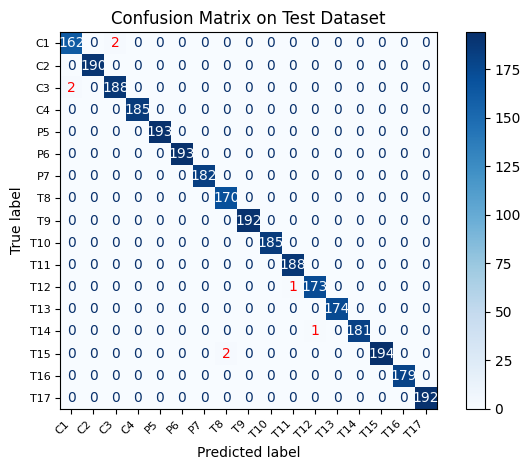

In [ ]:
plt.figure(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_label_mapping)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Show integers
disp.ax_.set_xticklabels(short_label_mapping, rotation=45, ha='right', fontsize=8)
disp.ax_.set_yticklabels(short_label_mapping, fontsize=8)
disp.ax_.set_title('Confusion Matrix on Test Dataset', fontsize=12)

# Highlight misclassifications (off-diagonal) in red
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            disp.text_[i, j].set_color('red')  # Color misclassifications red

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

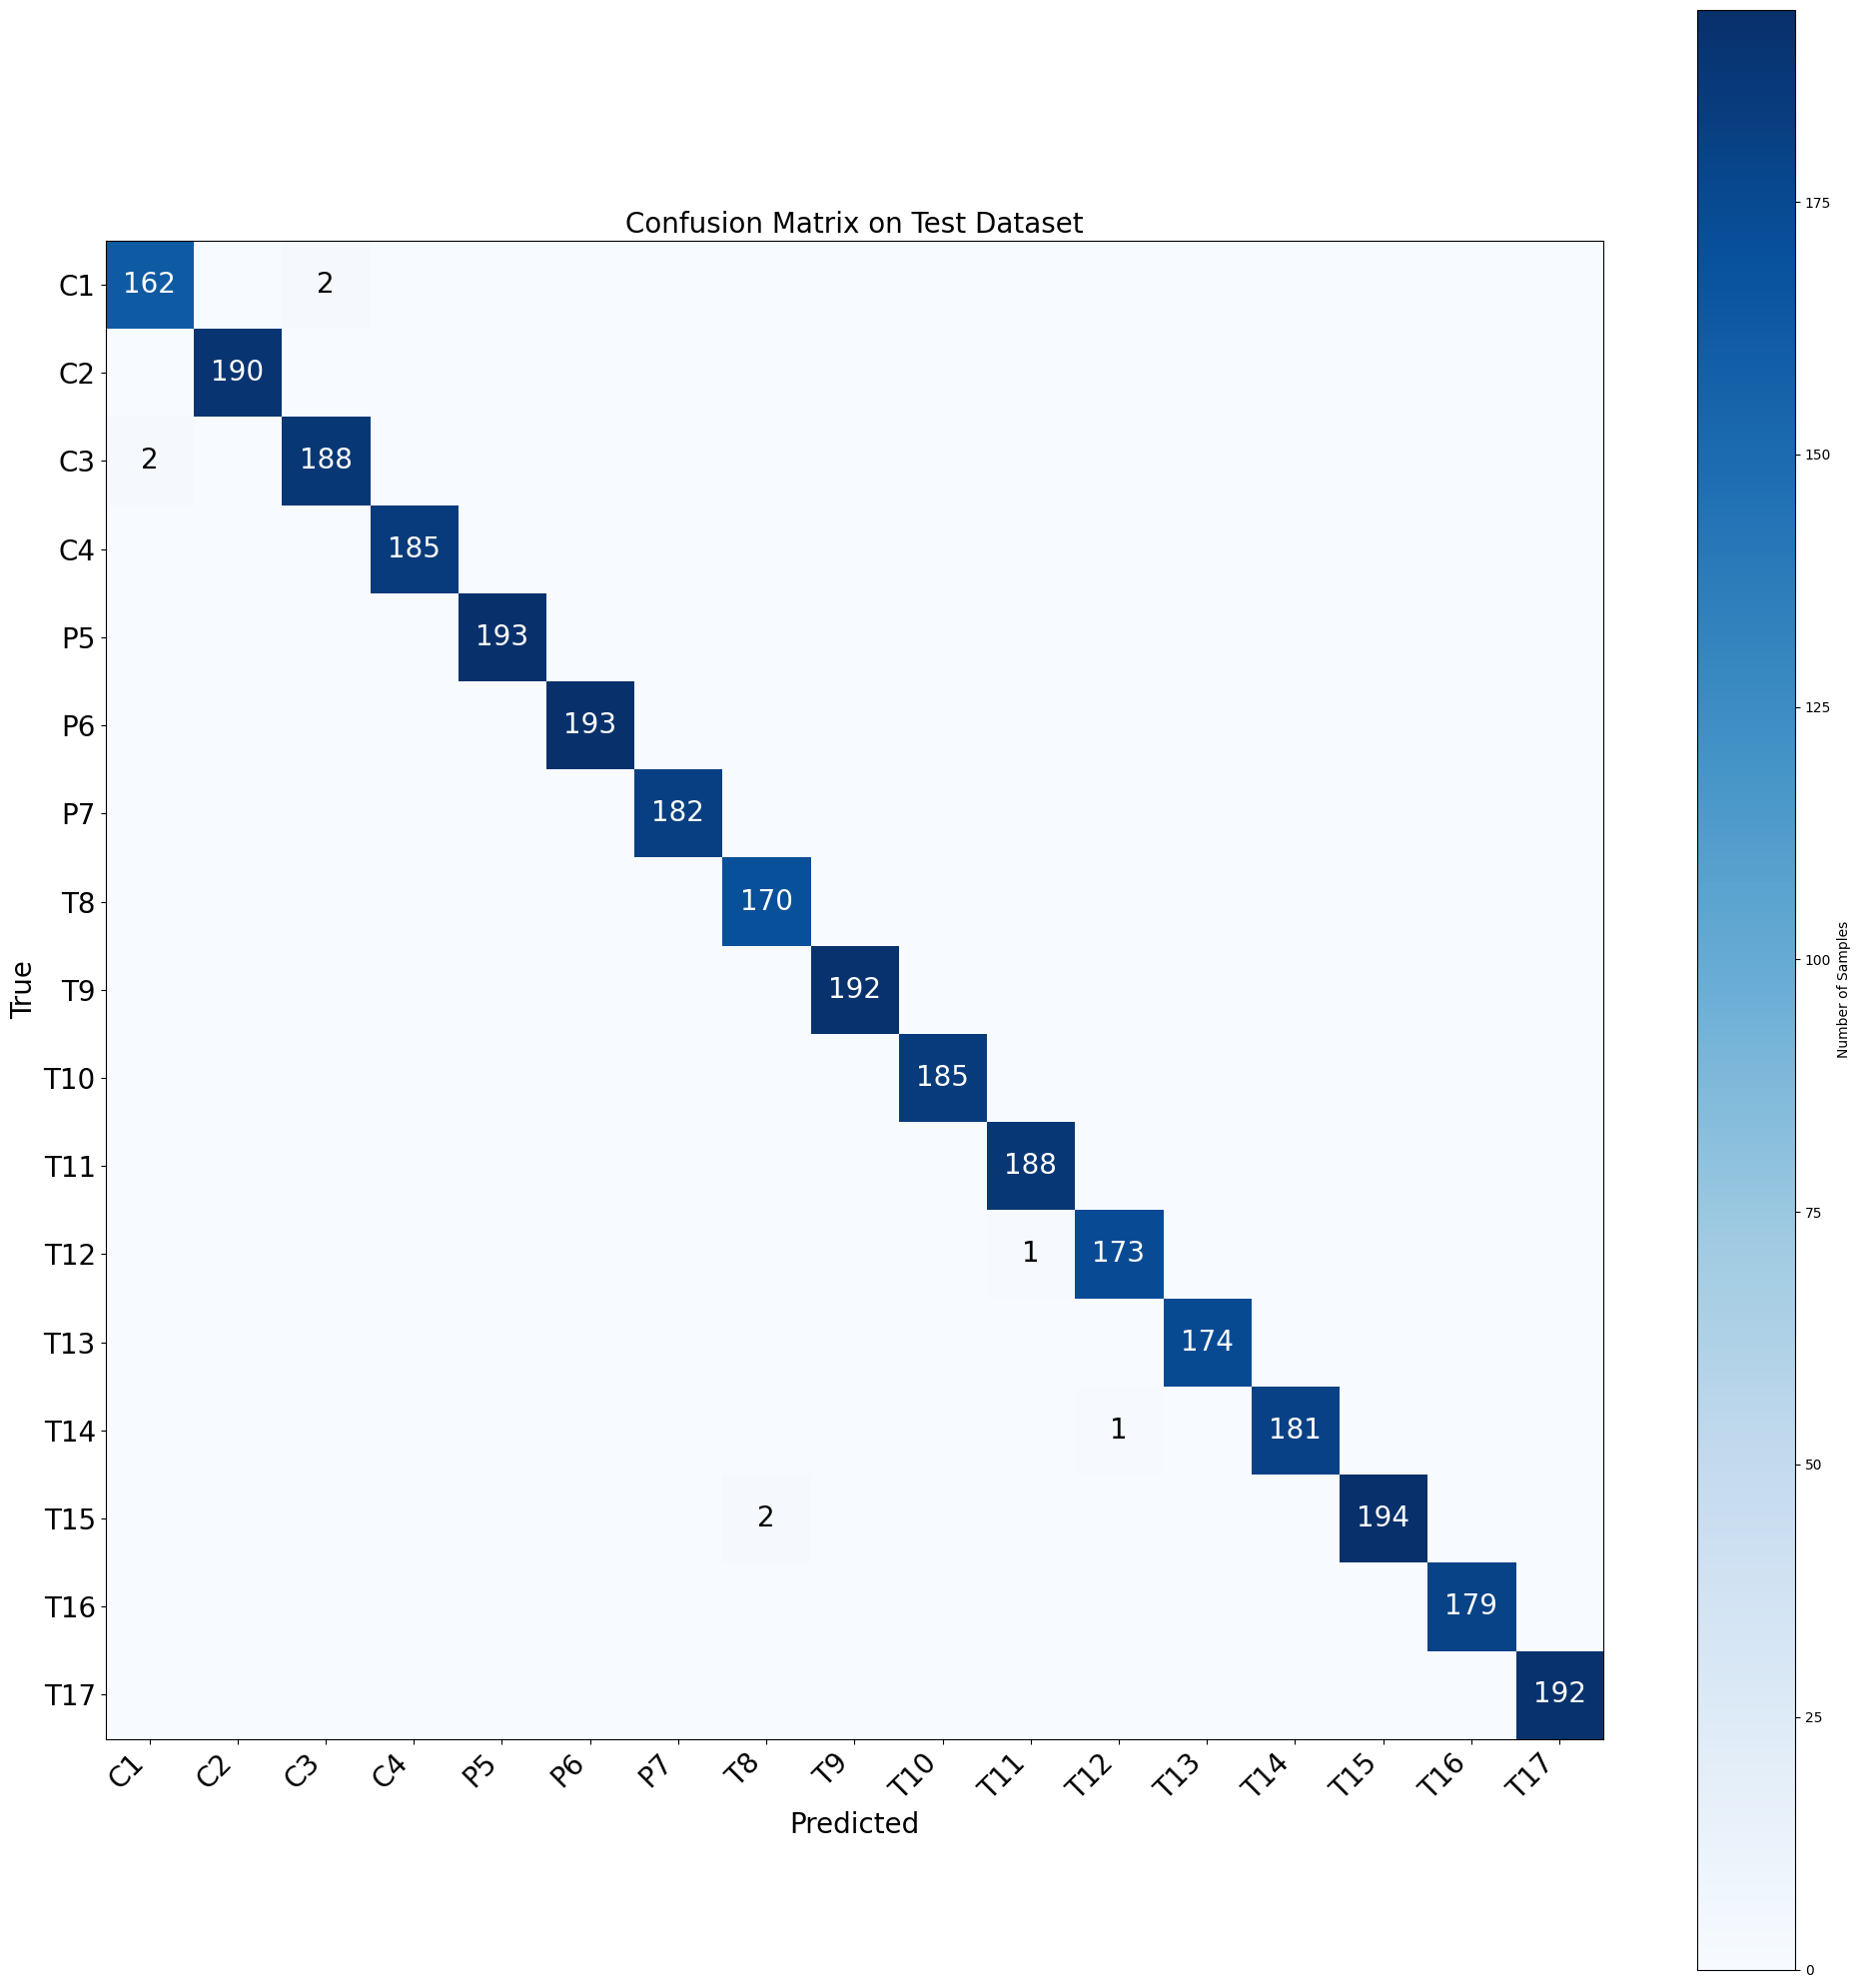

In [ ]:
# Plot heatmap with labels

plt.figure(figsize=(20, 20))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Number of Samples')

# Add labels to axes
plt.xticks(ticks=np.arange(len(short_label_mapping)), labels=short_label_mapping, rotation=45, ha='right', fontsize=20)
plt.yticks(ticks=np.arange(len(short_label_mapping)), labels=short_label_mapping, fontsize=20)

# Add title and axis labels
plt.title('Confusion Matrix on Test Dataset', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)

# Add numbers to non-zero cells for clarity
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] > 0:
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > 50 else 'black', fontsize=20)

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.savefig('confusion_matrix_heatmap_with_labels.png')
plt.show()

In [ ]:
# Extract training history
training_history = trainer.state.log_history
logger.info(f"Extracted {len(training_history)} log entries from training history")


2025-03-19 20:40:59,830 - Extracted 254 log entries from training history


In [ ]:
# Extract losses and steps

train_losses = [x.get('loss') for x in training_history if 'loss' in x and 'eval_loss' not in x]
eval_losses = [x.get('eval_loss') for x in training_history if 'eval_loss' in x]
train_steps = [x['step'] for x in training_history if 'loss' in x and 'eval_loss' not in x]
eval_steps = [x['step'] for x in training_history if 'eval_loss' in x]

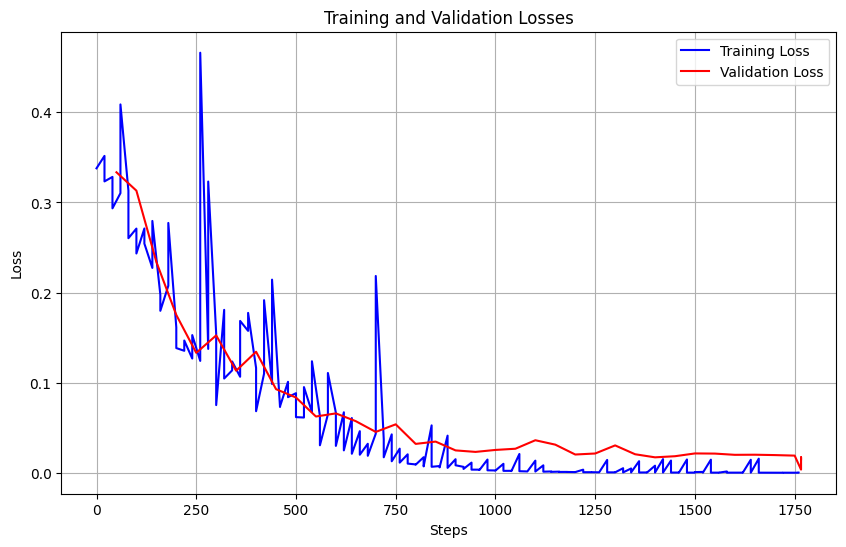

In [ ]:
# Plot losses over steps
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, 'b-', label='Training Loss')
plt.plot(eval_steps, eval_losses, 'r-', label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over steps')
plt.legend()
plt.grid(True)
plt.savefig('losses_over_steps.png')
plt.show()

In [ ]:
# Extract losses per epochs

epochs = sorted(set([int(round(x['epoch'])) for x in training_history if 'epoch' in x]))
train_losses_per_epoch = [np.mean([x['loss'] for x in training_history if 'loss' in x and 'eval_loss' not in x and int(round(x['epoch'])) == e]) for e in epochs]
eval_losses_per_epoch = [np.mean([x['eval_loss'] for x in training_history if 'eval_loss' in x and int(round(x['epoch'])) == e]) or None for e in epochs]

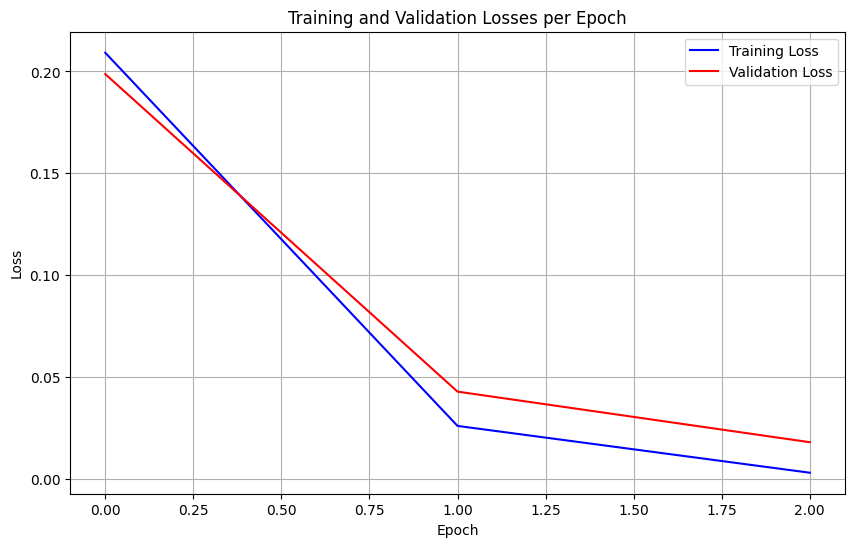

In [ ]:
# Losses per epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses_per_epoch, 'b-', label='Training Loss')
plt.plot(epochs, eval_losses_per_epoch, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('losses_per_epoch.png')
plt.show()

In [ ]:
# Metrics
train_accuracies = [x.get('train_accuracy') for x in training_history if 'train_accuracy' in x]
train_acc_steps = [x['step'] for x in training_history if 'train_accuracy' in x]
eval_metrics = [x for x in training_history if 'eval_accuracy' in x]
accuracies = [x['eval_accuracy'] for x in eval_metrics]
precisions = [x['eval_precision'] for x in eval_metrics]
recalls = [x['eval_recall'] for x in eval_metrics]
f1_scores = [x['eval_f1'] for x in eval_metrics]

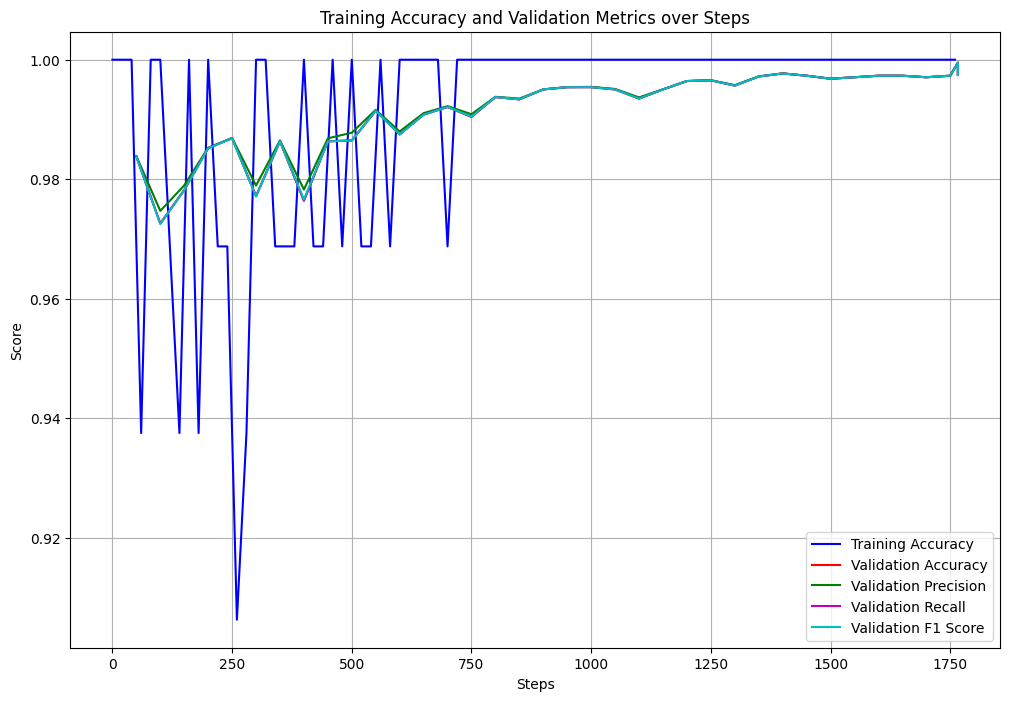

In [ ]:
# Plot 2: Metrics over Steps
plt.figure(figsize=(12, 8))
plt.plot(train_acc_steps, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(eval_steps, accuracies, 'r-', label='Validation Accuracy')
plt.plot(eval_steps, precisions, 'g-', label='Validation Precision')
plt.plot(eval_steps, recalls, 'm-', label='Validation Recall')
plt.plot(eval_steps, f1_scores, 'c-', label='Validation F1 Score')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.title('Training Accuracy and Validation Metrics over Steps')
plt.legend()
plt.grid(True)
plt.savefig('metrics_over_steps.png')
plt.show()

In [ ]:
# Metrics per epoch

train_acc_per_epoch = [np.mean([x['train_accuracy'] for x in training_history if 'train_accuracy' in x and int(round(x['epoch'])) == e]) for e in epochs]
eval_acc_per_epoch = [np.mean([x['eval_accuracy'] for x in training_history if 'eval_accuracy' in x and int(round(x['epoch'])) == e]) or None for e in epochs]
eval_prec_per_epoch = [np.mean([x['eval_precision'] for x in training_history if 'eval_precision' in x and int(round(x['epoch'])) == e]) or None for e in epochs]
eval_rec_per_epoch = [np.mean([x['eval_recall'] for x in training_history if 'eval_recall' in x and int(round(x['epoch'])) == e]) or None for e in epochs]
eval_f1_per_epoch = [np.mean([x['eval_f1'] for x in training_history if 'eval_f1' in x and int(round(x['epoch'])) == e]) or None for e in epochs]



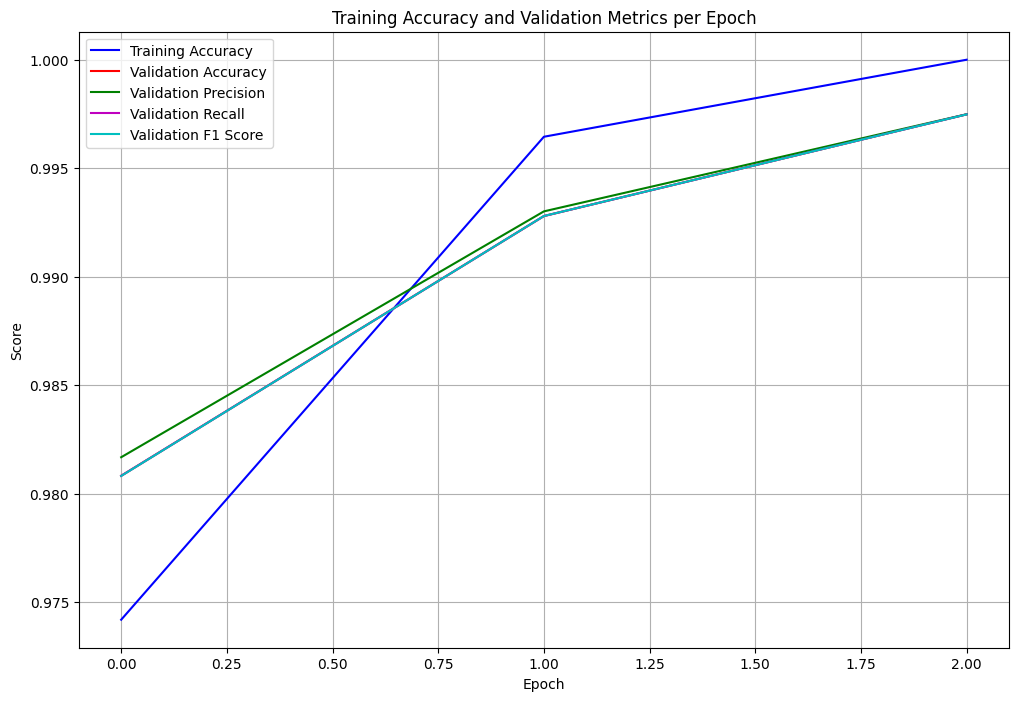

In [ ]:
# Plot 3: Metrics per Epoch
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc_per_epoch, 'b-', label='Training Accuracy')
plt.plot(epochs, eval_acc_per_epoch, 'r-', label='Validation Accuracy')
plt.plot(epochs, eval_prec_per_epoch, 'g-', label='Validation Precision')
plt.plot(epochs, eval_rec_per_epoch, 'm-', label='Validation Recall')
plt.plot(epochs, eval_f1_per_epoch, 'c-', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training Accuracy and Validation Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('metrics_per_epoch.png')
plt.show()

### [Inference](#-Inference)

In [ ]:

def predict_image(image_path, model_path=best_model_dir, label_names=None):

    """Predict the class of a single image using the best saved model.
     Args:
        image_path (str): Path to the image file.
        model_path (str): Path to the saved model directory (default: best_model_dir).
        label_names (list or dict, optional): List or mapping of label names. If None, attempts to load from model.
    """

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model directory not found: {model_path}")

    saved_model = ViTForImageClassification.from_pretrained(model_path)
    saved_processor = ViTImageProcessor.from_pretrained(model_path)

    if label_names is None:
        if hasattr(saved_model.config, 'id2label'):
            label_names = [saved_model.config.id2label[i] for i in range(len(saved_model.config.id2label))]
        else:
            raise ValueError("label_names not provided and could not be loaded from model...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    saved_model.to(device)
    saved_model.eval()

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        raise ValueError(f"Failed to load image {image_path}: {str(e)}")

    inputs = saved_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = saved_model(**inputs)
        logits = outputs.logits
        predictions = torch.softmax(logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()

    probs = predictions[0].cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Prediction: {label_names[predicted_class]}")
    plt.axis('off')

    top_5_indices = np.argsort(probs)[-5:][::-1]
    top_5_labels = [label_names[i] for i in top_5_indices]
    top_5_probs = probs[top_5_indices]
    plt.subplot(1, 2, 2)
    plt.barh(top_5_labels, top_5_probs)
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    plt.tight_layout()
    plt.show()

    logger.info(f"Predicted class: {label_names[predicted_class]} (index {predicted_class}) for {image_path}")
    return predicted_class, probs

2025-03-19 20:45:42,432 - Predicting on image with label names: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
loading configuration file /kaggle/working/plant-dataset/best-model/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Corn_(maize)___Cercospora_leaf_spot 

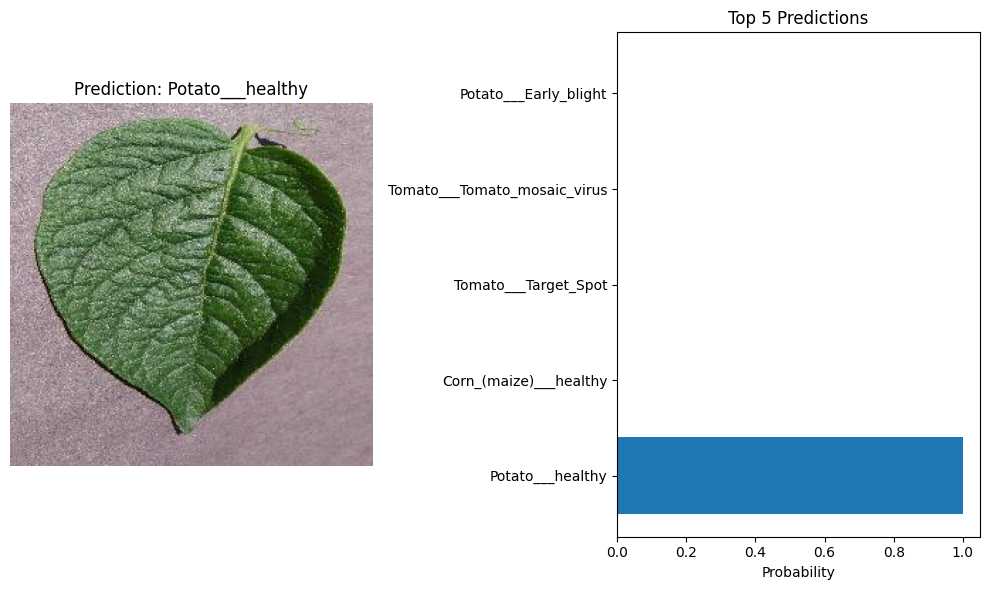

2025-03-19 20:45:43,008 - Predicted class: Potato___healthy (index 6) for /kaggle/working/plant-dataset/test/Potato___healthy/03da9931-e514-4cc7-b04a-8f474a133ce5___RS_HL 1830_flipTB.JPG


In [ ]:
labels = list(label_mapping.keys())
logger.info(f"Predicting on image with label names: {labels}")
image_path = '' # Define the path to the new image
predicted_class, probs = predict_image(image_path, label_names=labels)

In [ ]:
predicted_label = labels[predicted_class]
plant, disease = predicted_label.split('___')

print(f"Predicted Plant: {plant}")
print(f"Predicted Disease: {disease}")

Predicted Plant: Potato
Predicted Disease: healthy
